### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

### Carregamento do dados

In [2]:
dataOriginal = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 
df = dataOriginal 
#pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 

### Tratamento dos dados

In [3]:
# Assim, quando se mexe no dataset original, e se quer voltar atrás, temos o dataOriginal :)
if df['Profit'].isnull().sum() > 0:
    df = df[df['Profit'].notna()]

In [4]:
# Já está justificado no ficheiro data_exploration o porquê de removermos Códigos postais.
if 'Postal Code' in df.columns:
    df = df.drop('Postal Code', axis=1)

df = df.drop(columns = ['Sales'])

df = df.rename(columns = {'Shipping Cost':'Shipping_Cost'})
df = df.rename(columns = {'Order Priority':'Order_Priority'})

#data['Product Name'] = data['Product Name'].mode().iloc[0]
#data.Order_Priority = most_imputer2.fit_transform(data[['Order_Priority']])

print("Total de valores nulos ")
print(df.isnull().sum())


Total de valores nulos 
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Quantity          0
Discount          0
Profit            0
Shipping_Cost     0
Order_Priority    0
dtype: int64


In [5]:
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['City'] = df['City'].astype('category')
df['State'] = df['State'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Market'] = df['Market'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')
#df['Orde Priority'] = df['Order Priority'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51200 entries, 32298 to 6147
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Order ID        51200 non-null  object  
 1   Order Date      51200 non-null  object  
 2   Ship Date       51200 non-null  object  
 3   Ship Mode       51200 non-null  category
 4   Customer ID     51200 non-null  object  
 5   Customer Name   51200 non-null  object  
 6   Segment         51200 non-null  category
 7   City            51200 non-null  category
 8   State           51200 non-null  category
 9   Country         51200 non-null  category
 10  Market          51200 non-null  category
 11  Region          51200 non-null  category
 12  Product ID      51200 non-null  object  
 13  Category        51200 non-null  category
 14  Sub-Category    51200 non-null  category
 15  Product Name    51200 non-null  object  
 16  Quantity        51200 non-null  float64 
 17  Discount 

In [41]:
def show_frequencies_categorys():
    for coluna in df.select_dtypes(exclude=["number","bool_", "float64"]).columns:
        #print(coluna)
        if df[coluna].nunique() > 10 and ("Date" not in coluna) and ("ID" not in coluna):

            
            #df2=dfgroupby([coluna])[coluna].sum().rename("Courses_fee").groupby(level = 0).transform(lambda x: x/x.sum())
            coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
           # print(coluna_percentagens)
           # print("Exp:")
            values = coluna_percentagens.groupby(coluna_percentagens > 1).filter(lambda x: x.mean() > 1)
            if values.size > 0:
                print("\n", coluna, "'s com mais de 1% de valores\n")
                print(values)

# Juntar países e cidades cuja frequência é menor que uma especificada, para dados categóricos
# Esses dados são: "State", "City", "Country", "Market", "Region"
percentage = 1

#dataset = df.iloc[:]

dataset = df

for coluna in ["State", "City", "Country", "Region", "Sub-Category"]:

        #print(coluna)
        series = dataset.value_counts(dataset[coluna])
        mask = (series/series.sum() * 100).lt(percentage)
        #print(mask,"\n\n")
        dataset[coluna] = np.where(dataset[coluna].isin(series[mask].index),'Other',dataset[coluna])

df = dataset

show_frequencies_categorys()


 State 's com mais de 1% de valores

Other                     79.388672
California                 3.865234
England                    2.927734
New York                   2.187500
Ile-de-France              1.916016
Texas                      1.906250
New South Wales            1.525391
North Rhine-Westphalia     1.404297
Queensland                 1.400391
San Salvador               1.201172
Pennsylvania               1.138672
National Capital           1.138672
Name: State, dtype: float64

 Country 's com mais de 1% de valores

Other                 24.707031
United States         19.343750
Australia              5.541016
France                 5.521484
Mexico                 5.164062
Germany                4.033203
China                  3.671875
United Kingdom         3.189453
Brazil                 3.123047
India                  3.037109
Indonesia              2.714844
Turkey                 2.691406
Italy                  2.164062
Nigeria                1.767578
Spain         

In [42]:
data = df
number_bins = 6

if is_numeric_dtype(data['Discount']):
    # Bins in discount
    print("0 ", data['Discount'])
    min_value = data['Discount'].min()
    print("1", min_value)
    max_value = data['Discount'].max()
    print("2", max_value)
    limits_bins = np.linspace(min_value,max_value , num=number_bins)
    print("3", limits_bins)
    labels_names = []
    for i in range(0, len(limits_bins) - 1):
#    print("Olá")   
        v1 = '{:.2f}'.format(limits_bins[i])
        v2 = '{:.2f}'.format(limits_bins[i+1])
        labels_names.append(f'{v1}-{v2}')
    #print("v1: ", limits_bins[i])
    #print("v2: ", limits_bins[i+1])
    #print("----")
#    data4.loc[data4['score'].between(0, 50, 'both'), 'grade'] = 'C'
#print(labels_names)
    data['Discount'] = pd.cut(x = data['Discount'], bins = limits_bins, labels = labels_names, include_lowest = True)
    
df = data
print(df)

0  Row ID
32298    0.0
26341    0.1
25330    0.1
13524    0.1
47221    0.0
        ... 
24175    0.1
29002    0.0
35398    0.8
9596     0.0
6147     0.0
Name: Discount, Length: 51200, dtype: float64
1 0.0
2 0.85
3 [0.   0.17 0.34 0.51 0.68 0.85]
               Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
Row ID                                                                        
32298    CA-2012-124891  31-07-2012  31-07-2012        Same Day    RH-19495   
26341     IN-2013-77878  05-02-2013  07-02-2013    Second Class    JR-16210   
25330     IN-2013-71249  17-10-2013  18-10-2013     First Class    CR-12730   
13524   ES-2013-1579342  28-01-2013  30-01-2013     First Class    KM-16375   
47221      SG-2013-4320  05-11-2013  06-11-2013        Same Day     RH-9495   
...                 ...         ...         ...             ...         ...   
24175     IN-2014-57662  05-08-2014  10-08-2014  Standard Class    DB-13270   
29002     IN-2014-62366  19-06-2014  19-06-

In [43]:
# Tratar das datas
data2 = df

if "Order Date" in data2:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
    
# Converter datas, acho que já está feito em cima, depois confirmar
dates_order = DatetimeIndex(pd.to_datetime(data2['Order Date'],format='%d-%m-%Y', errors='coerce'))
dates_ship = DatetimeIndex(pd.to_datetime(data2['Ship Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    data2['Year_order'] = dates_order.year
    data2['Year_ship'] = dates_ship.year
    
if consider_month : 
    data2['Month_order'] = dates_order.month
    data2['Month_ship'] = dates_ship.month

if consider_day : 
    data2['Day_order'] = dates_order.day
    data2['Day_ship'] = dates_ship.day
if 'Order Date' in data2:
    data2 = data2.drop(['Order Date', 'Ship Date'], axis=1)

df = data2

In [78]:
# Juntar datasets de países com PIB por anos


df_pib = pd.read_csv('pibs.csv')


# Nós criamos um dicionário que associa o país ao index para depois a procura ser mais rápida
# A key é o país, o value é o index no dataframe
countries_index = {}
for index, row in df_pib.iterrows():
#    countries_index[row['Country Name']] = index
    countries_index[row['Country Name']] = index
    


0      2.549721e+09
1      9.433780e+11
2      1.780511e+10
3      6.709630e+11
4      1.117900e+11
           ...     
261    6.341737e+09
262    3.272642e+10
263    4.582020e+11
264    2.345952e+10
265    1.410192e+10
Name: 2011, Length: 266, dtype: float64


In [93]:
df_copy = df

available_years = [2011, 2012, 2013, 2014]

def convert_countries_name(value):
    if (value=='Iran'):
        return "Iran, Islamic Rep."
    else:
        return value

def add_pib_value():
    gdp_by_years = {}
    for year in available_years:
        
        gdp_by_years[year] = df_pib[str(year)].quantile([0.25])
    return gdp_by_years

gdp_to_Other_countries_dic = add_pib_value()

#print(gdp_to_Other_countries_dic)

def add_pib_value(value):
    #print(value)
   # print(df_pib.loc[df_pib['Country Name'] == value])
    country = convert_countries_name(value['Country'])
    year = value['Year_order']
    if (country == 'Other'):
        return gdp_to_Other_countries_dic[year]
    index_in_df = countries_index[country]
    
    gdp_in_year = df_pib.iloc[index_in_df]
    #Corresponder o ano ao index no df de pib
    year_index = year-2011+1;
    #print("init")
    #print(gdp_in_year)
  #  print(country)
  #  print(year)
  #  print(gdp_in_year[year_index])
    #print("----fim")
#    print(gdp_in_year.year)
    return gdp_in_year[year_index]

df_copy['pib_country'] = df_copy.apply (lambda row: add_pib_value(row), axis=1)
print(df_copy.head(5))
#df_copy['country_pib'] = df['Country'].map(add_pib_value)

               Order ID Ship Mode     Customer Name      Segment  \
Row ID                                                             
32298    CA-2012-124891         1       Rick Hansen     Consumer   
26341     IN-2013-77878         3     Justin Ritter    Corporate   
25330     IN-2013-71249         2      Craig Reiter     Consumer   
13524   ES-2013-1579342         2  Katherine Murray  Home Office   
47221      SG-2013-4320         1       Rick Hansen     Consumer   

                 City            State        Country  Market   Region  \
Row ID                                                                   
32298   New York City         New York  United States      US     East   
26341           Other  New South Wales      Australia    APAC  Oceania   
25330           Other       Queensland      Australia    APAC  Oceania   
13524           Other            Other        Germany      EU  Central   
47221           Other            Other          Other  Africa   Africa   

    

In [46]:
# Label encoding de algumas variáveis

if "Category" in data2:
    process_Product_ID = True
    process_Costumer_ID = True
    process_Category = True
    process_Sub_Category = True
    process_Discount = True
else: 
    process_Product_ID = False
    process_Costumer_ID = False
    process_Category = False
    process_Sub_Category = False
    process_Discount = False

lb_make = LabelEncoder()

if process_Product_ID:
    data2["Product ID LabelEnc"] = lb_make.fit_transform(data2["Product ID"])

if process_Costumer_ID:
    data2["Costumer ID LabelEnc"] = lb_make.fit_transform(data2["Customer ID"])

if process_Category:
    data2["Category LabelEnc"] = lb_make.fit_transform(data2["Category"])

if process_Sub_Category:
    data2["Sub-Category LabelEnc"] = lb_make.fit_transform(data2["Sub-Category"])
    
if process_Discount:
    data2["Discount LabelEnc"] = lb_make.fit_transform(data2["Discount"])

    
if process_Product_ID: 
    data2 = data2.drop(['Product ID', 'Customer ID', "Category", "Sub-Category", "Discount"], axis=1)
#from pandas.api.types import is_string_dtype

if data2['Ship Mode'].dtype == 'category' or data2['Ship Mode'].dtype == 'object':
   # print("Ship mode ainda está em categorias")
    #print(data2['Ship Mode'].unique())
    ship_mode_dic = {'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4}
    #dataTemp = pd.DataFrame({"Ship Mode": ship_mode_dic.keys()})
    #print("Aqui vai\n")
    data2["Ship Mode"]= data2["Ship Mode"].apply(lambda x: ship_mode_dic.get(x))
    #print(data2)

if "Order_Priority" in data2 and (data2['Order_Priority'].dtype == 'category' or data2['Order_Priority'].dtype == 'object'):
    dataTemp = data2
    # print("Ship mode ainda está em categorias")
    #print(dataTemp['Order_Priority'].unique())
    priorities_dic = {'Critical':1, 'High':2, 'Medium':3,'Low':4}
    #dataTemp = pd.DataFrame({"Order_Priority": priorities_dic.keys()})
    #print("Aqui vai\n")
    dataTemp["Order_Priority"]= dataTemp["Order_Priority"].apply(lambda x: priorities_dic.get(x))
    #print(dataTemp.info())
    data2 = dataTemp
    
print("\nApós fazer Label Encoding")
print(data2)

df = data2


Após fazer Label Encoding
               Order ID Ship Mode      Customer Name      Segment  \
Row ID                                                              
32298    CA-2012-124891         1        Rick Hansen     Consumer   
26341     IN-2013-77878         3      Justin Ritter    Corporate   
25330     IN-2013-71249         2       Craig Reiter     Consumer   
13524   ES-2013-1579342         2   Katherine Murray  Home Office   
47221      SG-2013-4320         1        Rick Hansen     Consumer   
...                 ...       ...                ...          ...   
24175     IN-2014-57662         4  Deborah Brumfield  Home Office   
29002     IN-2014-62366         1    Katrina Edelman    Corporate   
35398    US-2014-102288         4   Zuschuss Carroll     Consumer   
9596     MX-2012-140767         4         Ross Baird  Home Office   
6147     MX-2012-134460         3      Mick Crebagga     Consumer   

                 City            State        Country  Market      Region  

<AxesSubplot:>

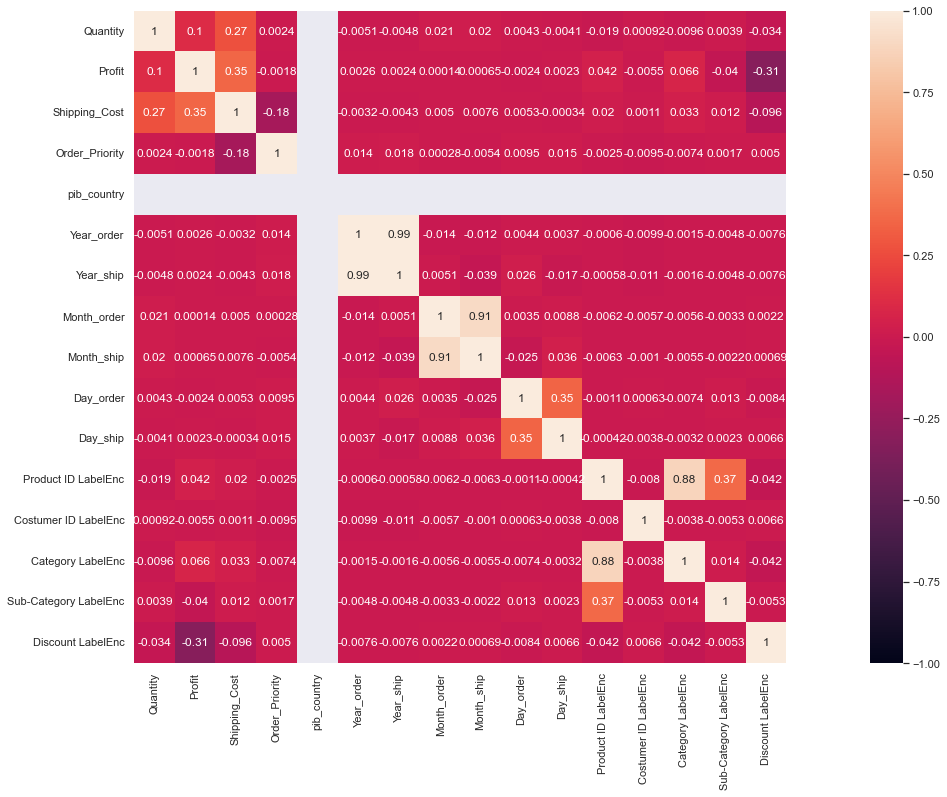

In [47]:
corr_matrix = df.corr()
sns.set(rc={'figure.figsize':(30,12)})
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True,annot=True)

<AxesSubplot:ylabel='Row ID'>

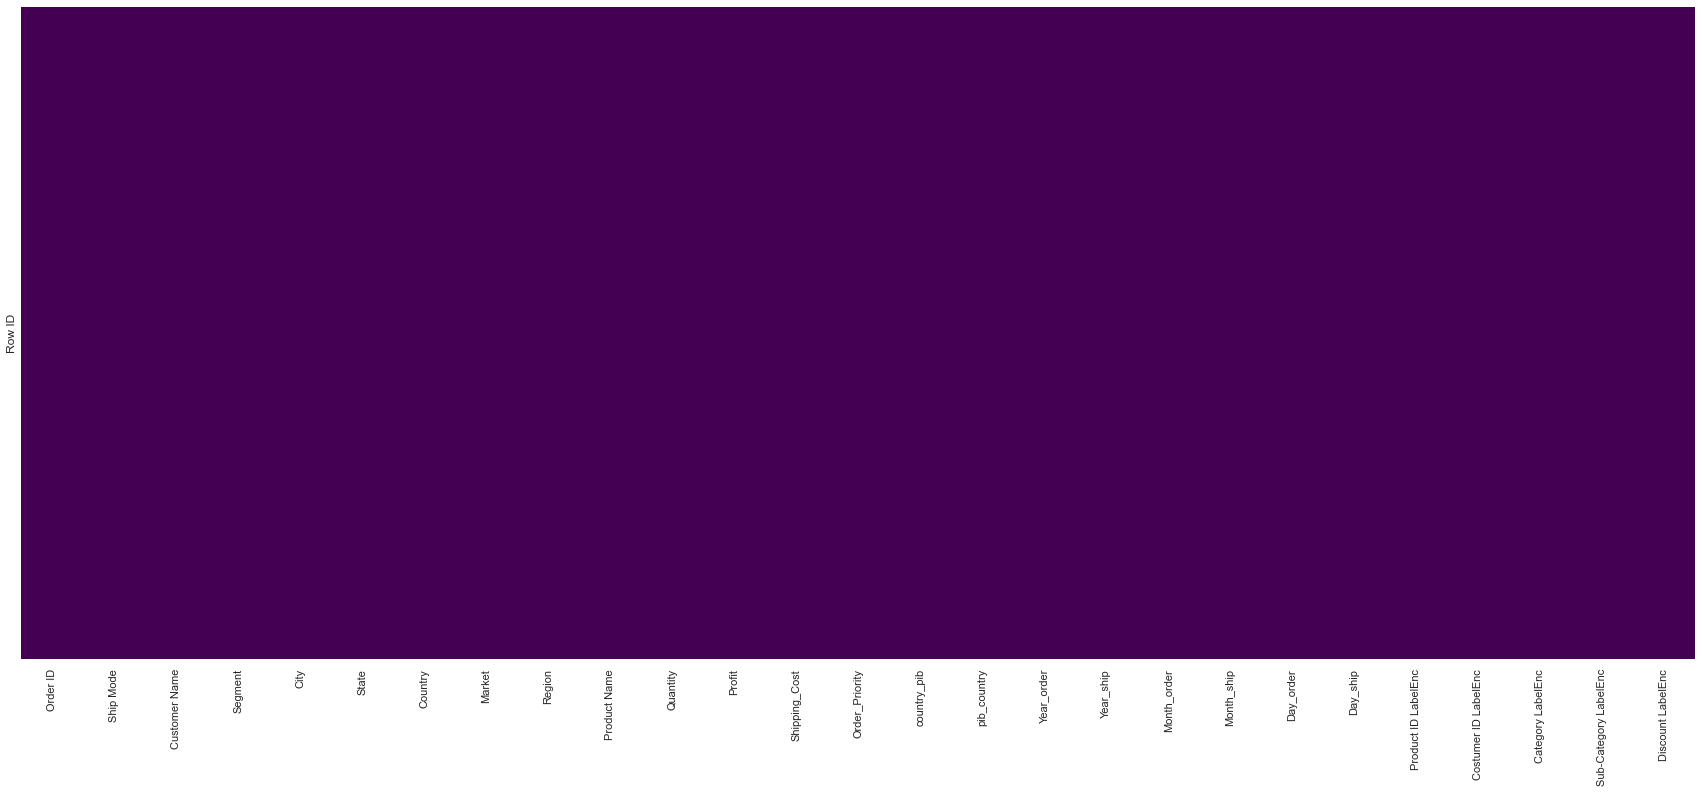

In [48]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [49]:
data4 = df 
#number_bins = 2

if (data4['Ship Mode'].dtypes == 'category'):

    # 'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4
    data4.loc[data4['Ship Mode'] == 4 ,'Ship_mode_binned'] = 0
    data4.loc[data4['Ship Mode'] != 4 ,'Ship_mode_binned'] = 1
    
df = data4
print(df)  

               Order ID Ship Mode      Customer Name      Segment  \
Row ID                                                              
32298    CA-2012-124891         1        Rick Hansen     Consumer   
26341     IN-2013-77878         3      Justin Ritter    Corporate   
25330     IN-2013-71249         2       Craig Reiter     Consumer   
13524   ES-2013-1579342         2   Katherine Murray  Home Office   
47221      SG-2013-4320         1        Rick Hansen     Consumer   
...                 ...       ...                ...          ...   
24175     IN-2014-57662         4  Deborah Brumfield  Home Office   
29002     IN-2014-62366         1    Katrina Edelman    Corporate   
35398    US-2014-102288         4   Zuschuss Carroll     Consumer   
9596     MX-2012-140767         4         Ross Baird  Home Office   
6147     MX-2012-134460         3      Mick Crebagga     Consumer   

                 City            State        Country  Market      Region  \
Row ID                   

In [50]:
data5 = df 
#number_bins = 2

if (data5['Market'].dtypes == 'category'):

    data5.loc[data4['Market'] == 'Canada' ,'Market_binned'] = 'Canada and US'
    data5.loc[data4['Market'] == 'US' ,'Market_binned'] = 'Canada and US'
    data5.loc[data4['Market'] == 'APAC' ,'Market_binned'] = 'APAC'
    data5.loc[data4['Market'] == 'EU' ,'Market_binned'] = 'EU'
    data5.loc[data4['Market'] == 'Africa' ,'Market_binned'] = 'Africa'
    data5.loc[data4['Market'] == 'EMEA' ,'Market_binned'] = 'EMEA'
    data5.loc[data4['Market'] == 'LATAM' ,'Market_binned'] = 'LATAM'
    
df = data5
print(df)  

               Order ID Ship Mode      Customer Name      Segment  \
Row ID                                                              
32298    CA-2012-124891         1        Rick Hansen     Consumer   
26341     IN-2013-77878         3      Justin Ritter    Corporate   
25330     IN-2013-71249         2       Craig Reiter     Consumer   
13524   ES-2013-1579342         2   Katherine Murray  Home Office   
47221      SG-2013-4320         1        Rick Hansen     Consumer   
...                 ...       ...                ...          ...   
24175     IN-2014-57662         4  Deborah Brumfield  Home Office   
29002     IN-2014-62366         1    Katrina Edelman    Corporate   
35398    US-2014-102288         4   Zuschuss Carroll     Consumer   
9596     MX-2012-140767         4         Ross Baird  Home Office   
6147     MX-2012-134460         3      Mick Crebagga     Consumer   

                 City            State        Country  Market      Region  \
Row ID                   

In [51]:
df.to_csv("new_Global_Superstore2.csv")

In [52]:
#código que na feature order priority, junta o low com o medium e o critical com o high (não colocar no ficheiro das redes neuronais)
data6 = df 

if (data6['Order_Priority'].dtypes == 'int64'):

    #Critical:1, High:2, Medium:3, Low:4
    data6.loc[data6['Order_Priority'] == 3 ,'Order_priority_binned'] = 0
    data6.loc[data6['Order_Priority'] == 4 ,'Order_priority_binned'] = 0
    data6.loc[data6['Order_Priority'] == 2 ,'Order_priority_binned'] = 1
    data6.loc[data6['Order_Priority'] == 1 ,'Order_priority_binned'] = 1
    
df = data6
print(df)  

               Order ID Ship Mode      Customer Name      Segment  \
Row ID                                                              
32298    CA-2012-124891         1        Rick Hansen     Consumer   
26341     IN-2013-77878         3      Justin Ritter    Corporate   
25330     IN-2013-71249         2       Craig Reiter     Consumer   
13524   ES-2013-1579342         2   Katherine Murray  Home Office   
47221      SG-2013-4320         1        Rick Hansen     Consumer   
...                 ...       ...                ...          ...   
24175     IN-2014-57662         4  Deborah Brumfield  Home Office   
29002     IN-2014-62366         1    Katrina Edelman    Corporate   
35398    US-2014-102288         4   Zuschuss Carroll     Consumer   
9596     MX-2012-140767         4         Ross Baird  Home Office   
6147     MX-2012-134460         3      Mick Crebagga     Consumer   

                 City            State        Country  Market      Region  \
Row ID                   